# Задание

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перрасчет (ресемплинг) в представление по 1 месяцу.


In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore") 

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

%matplotlib inline
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

In [2]:
data = pd.read_csv('my_PJME_MW.csv', index_col=[0], parse_dates=[0])

In [3]:
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [4]:
data = data.resample("M").apply('mean')

In [5]:
data['PJME_MW'].values.shape

(200,)

2. Подберите параметры модели SARIMAX для этого ряда.


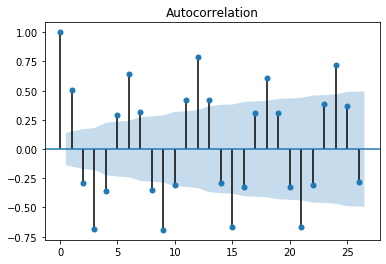

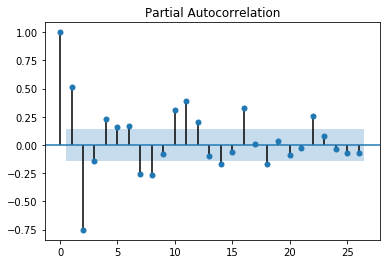

In [6]:
sm.graphics.tsa.plot_acf(data['PJME_MW'].values, lags=26)
plt.show()
sm.graphics.tsa.plot_pacf(data['PJME_MW'].values, lags=26)
plt.show()

Сезонность видна из ACF - лаг 12 дает большую корреляцию. чем лаг 6 - сезон = 12

проверим интуитивную модель с сезоном 12 и зададим глубину истории и сглаживания 2.

In [7]:
result = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[2,0, 2],seasonal_order=[0,0,0,12],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
result_s = result.fit() 

Сравним эту модель с подбором модели по сетке

Сезонность определили - 12
порядок глубины истории для сезонности не более 3 (ACF: лаг 12 и 24 выше синенькой полосы , вот 36 видимо будет уже в ней - т.о. берем не более 3-х лет истории по сезонам и не менее 1-го )
Сглаживание определим тоже до 3-х 
порядок интегрирования не берем больше 2 - иначе будет очень сложная модель.

Для остатков сезонной модели - ряд достаточно гладкий - мало измерений - ограничим сложность по h и q до 3, а по d не более 2- 

In [8]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)
# зададим сетку p, q и q для сезонов
pdq = list(itertools.product(p, d, q))
p = range(1, 3)
d = range(0, 2)
q = range(0, 3)
seasonal_pdq = list(itertools.product(p, d, q, [12]))#[0,0,0,52] # нет сезона

aics = {}

for kk in range(len(pdq)):
    for k in range(len(seasonal_pdq)):
        param = pdq[kk]
        params=seasonal_pdq[k]
        print(seasonal_pdq[k])
        try:
            mod_b = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                              order=param,seasonal_order=params,trend='ct',
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

            results_ = mod_b.fit()
            aics[results_.aic] = param
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results_.aic))
        except:
            continue

(1, 0, 0, 12)
ARIMA(0, 0, 0)x(1, 0, 0, 12) - AIC:1679.1385187968067
(1, 0, 1, 12)
ARIMA(0, 0, 0)x(1, 0, 1, 12) - AIC:1610.6418381463664
(1, 0, 2, 12)
ARIMA(0, 0, 0)x(1, 0, 2, 12) - AIC:1400.1318847474731
(1, 1, 0, 12)
ARIMA(0, 0, 0)x(1, 1, 0, 12) - AIC:1350.6887580132757
(1, 1, 1, 12)
ARIMA(0, 0, 0)x(1, 1, 1, 12) - AIC:1338.699725331018
(1, 1, 2, 12)
ARIMA(0, 0, 0)x(1, 1, 2, 12) - AIC:2748.7914782767148
(2, 0, 0, 12)
ARIMA(0, 0, 0)x(2, 0, 0, 12) - AIC:1448.2827288969768
(2, 0, 1, 12)
ARIMA(0, 0, 0)x(2, 0, 1, 12) - AIC:1422.1458304158664
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 12) - AIC:1401.9834517137442
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 1, 0, 12) - AIC:1127.3878984412695
(2, 1, 1, 12)
ARIMA(0, 0, 0)x(2, 1, 1, 12) - AIC:1132.0921181407316
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:2201.0642359140807
(1, 0, 0, 12)
ARIMA(0, 0, 1)x(1, 0, 0, 12) - AIC:1649.3628442394383
(1, 0, 1, 12)
ARIMA(0, 0, 1)x(1, 0, 1, 12) - AIC:1602.8955450477238
(1, 0, 2, 12)
ARIMA(0, 0, 1)x(1, 0, 2, 12) - AIC:1379.449901573448
(1, 1, 0, 12)
ARIMA(0, 0, 1)x(1, 1, 0, 12) - AIC:1352.800185432112
(1, 1, 1, 12)
ARIMA(0, 0, 1)x(1, 1, 1, 12) - AIC:1321.9336893020786
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 1, 2, 12) - AIC:2064.3946220276202
(2, 0, 0, 12)
ARIMA(0, 0, 1)x(2, 0, 0, 12) - AIC:1425.232122092913
(2, 0, 1, 12)
ARIMA(0, 0, 1)x(2, 0, 1, 12) - AIC:1420.915151562932
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 0, 2, 12) - AIC:1380.4481982434002
(2, 1, 0, 12)
ARIMA(0, 0, 1)x(2, 1, 0, 12) - AIC:1136.5891337250207
(2, 1, 1, 12)
ARIMA(0, 0, 1)x(2, 1, 1, 12) - AIC:1133.3398621161468
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 2, 12) - AIC:2033.1912565322116
(1, 0, 0, 12)
ARIMA(0, 0, 2)x(1, 0, 0, 12) - AIC:1624.1024525119046
(1, 0, 1, 12)
ARIMA(0, 0, 2)x(1, 0, 1, 12) - AIC:1572.8810226323753
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 0, 2, 12) - AIC:1353.714493378435
(1, 1, 0, 12)
ARIMA(0, 0, 2)x(1, 1, 0, 12) - AIC:1355.522908169868
(1, 1, 1, 12)
ARIMA(0, 0, 2)x(1, 1, 1, 12) - AIC:1306.144210246783
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(1, 1, 2, 12) - AIC:2572.8459030119675
(2, 0, 0, 12)
ARIMA(0, 0, 2)x(2, 0, 0, 12) - AIC:1414.8637900622819
(2, 0, 1, 12)
ARIMA(0, 0, 2)x(2, 0, 1, 12) - AIC:1410.1846759233763
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 12) - AIC:1355.3303940406638
(2, 1, 0, 12)
ARIMA(0, 0, 2)x(2, 1, 0, 12) - AIC:1137.611489284886
(2, 1, 1, 12)
ARIMA(0, 0, 2)x(2, 1, 1, 12) - AIC:1134.6266374391162
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 2, 12) - AIC:2473.4022179765047
(1, 0, 0, 12)
ARIMA(0, 1, 0)x(1, 0, 0, 12) - AIC:1594.1359789817602
(1, 0, 1, 12)
ARIMA(0, 1, 0)x(1, 0, 1, 12) - AIC:1565.7238032861085
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 0, 2, 12) - AIC:1339.4610081952544
(1, 1, 0, 12)
ARIMA(0, 1, 0)x(1, 1, 0, 12) - AIC:1370.8948773572222
(1, 1, 1, 12)
ARIMA(0, 1, 0)x(1, 1, 1, 12) - AIC:1348.4492057188706
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(1, 1, 2, 12) - AIC:2262.831221450616
(2, 0, 0, 12)
ARIMA(0, 1, 0)x(2, 0, 0, 12) - AIC:1368.8184438978487
(2, 0, 1, 12)
ARIMA(0, 1, 0)x(2, 0, 1, 12) - AIC:1364.4987886262809
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 0, 2, 12) - AIC:1339.935014987848
(2, 1, 0, 12)
ARIMA(0, 1, 0)x(2, 1, 0, 12) - AIC:1142.156155478491
(2, 1, 1, 12)
ARIMA(0, 1, 0)x(2, 1, 1, 12) - AIC:1143.5041671900883
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 0)x(2, 1, 2, 12) - AIC:2390.1103176555202
(1, 0, 0, 12)
ARIMA(0, 1, 1)x(1, 0, 0, 12) - AIC:1586.8483717115141
(1, 0, 1, 12)
ARIMA(0, 1, 1)x(1, 0, 1, 12) - AIC:1525.8300670870801
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 0, 2, 12) - AIC:1304.1548706911651
(1, 1, 0, 12)
ARIMA(0, 1, 1)x(1, 1, 0, 12) - AIC:1351.9533704534401
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12) - AIC:1302.3335501765614
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 1, 2, 12) - AIC:2936.6906927869372
(2, 0, 0, 12)
ARIMA(0, 1, 1)x(2, 0, 0, 12) - AIC:1345.0598978228447
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 1, 12) - AIC:1344.4375548363828
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 0, 2, 12) - AIC:1324.4156113412093
(2, 1, 0, 12)
ARIMA(0, 1, 1)x(2, 1, 0, 12) - AIC:1130.77731038233
(2, 1, 1, 12)
ARIMA(0, 1, 1)x(2, 1, 1, 12) - AIC:1131.0778879553288
(2, 1, 2, 12)
ARIMA(0, 1, 1)x(2, 1, 2, 12) - AIC:2675.53105733239
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 0, 12) - AIC:1586.539581316792
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 1, 12) - AIC:1503.4127840336823
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 0, 2, 12) - AIC:1287.0017202143058
(1, 1, 0, 12)
ARIMA(0, 1, 2)x(1, 1, 0, 12) - AIC:1352.665111180172
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 1, 12) - AIC:1284.2786931401286
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 1, 2, 12) - AIC:2254.0086454846632
(2, 0, 0, 12)
ARIMA(0, 1, 2)x(2, 0, 0, 12) - AIC:1350.5584175720778
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12) - AIC:1358.1738712415388
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 2, 12) - AIC:1313.2783571219975
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12) - AIC:1125.743779805183
(2, 1, 1, 12)
ARIMA(0, 1, 2)x(2, 1, 1, 12) - AIC:1133.0711603037357
(2, 1, 2, 12)
ARIMA(0, 1, 2)x(2, 1, 2, 12) - AIC:3481.610614200925
(1, 0, 0, 12)
ARIMA(1, 0, 0)x(1, 0, 0, 12) - AIC:1602.432824024966
(1, 0, 1, 12)
ARIMA(1, 0, 0)x(1, 0, 1, 12) - AIC:1603.4500522710455
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 0, 2, 12) - AIC:1382.9816656344012
(1, 1, 0, 12)
ARIMA(1, 0, 0)x(1, 1, 0, 12) - AIC:1334.8273580168611
(1, 1, 1, 12)
ARIMA(1, 0, 0)x(1, 1, 1, 12) - AIC:1337.6779829895233
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(1, 1, 2, 12) - AIC:3155.603411018817
(2, 0, 0, 12)
ARIMA(1, 0, 0)x(2, 0, 0, 12) - AIC:1380.4633974723336
(2, 0, 1, 12)
ARIMA(1, 0, 0)x(2, 0, 1, 12) - AIC:1380.8413419299573
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 2, 12) - AIC:1381.8684985097307
(2, 1, 0, 12)
ARIMA(1, 0, 0)x(2, 1, 0, 12) - AIC:1116.9639878345608
(2, 1, 1, 12)
ARIMA(1, 0, 0)x(2, 1, 1, 12) - AIC:1118.826350473356
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 1, 2, 12) - AIC:2329.820986400307
(1, 0, 0, 12)
ARIMA(1, 0, 1)x(1, 0, 0, 12) - AIC:1572.6554168691712
(1, 0, 1, 12)
ARIMA(1, 0, 1)x(1, 0, 1, 12) - AIC:1553.4393341802752
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 0, 2, 12) - AIC:1347.477917269777
(1, 1, 0, 12)
ARIMA(1, 0, 1)x(1, 1, 0, 12) - AIC:1336.383459687598
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12) - AIC:1316.7569440687414
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 1, 2, 12) - AIC:2589.4666137186628
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 0, 12) - AIC:1359.418987467266
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 12) - AIC:1354.4170399355037
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 12) - AIC:1344.8672469655182
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 0, 12) - AIC:1113.0756838620482
(2, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 1, 12) - AIC:1117.4482029976173
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 1, 2, 12) - AIC:2529.570067040645
(1, 0, 0, 12)
ARIMA(1, 0, 2)x(1, 0, 0, 12) - AIC:1590.5427815144812
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 1, 12) - AIC:1553.9668364142283
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 12) - AIC:1341.950494043462
(1, 1, 0, 12)
ARIMA(1, 0, 2)x(1, 1, 0, 12) - AIC:1337.6995842093265
(1, 1, 1, 12)
ARIMA(1, 0, 2)x(1, 1, 1, 12) - AIC:1299.58630915707
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 12) - AIC:2634.6277342691337
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12) - AIC:1372.030126396445
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12) - AIC:1376.3947454487188
(2, 0, 2, 12)
ARIMA(1, 0, 2)x(2, 0, 2, 12) - AIC:1342.1014408129226
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12) - AIC:1117.410012874758
(2, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 1, 12) - AIC:1121.9755885684774
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:2020.0003186188367
(1, 0, 0, 12)
ARIMA(1, 1, 0)x(1, 0, 0, 12) - AIC:1570.3048259343345
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 1, 12) - AIC:1558.7225198879812
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 0, 2, 12) - AIC:1330.8473119222665
(1, 1, 0, 12)
ARIMA(1, 1, 0)x(1, 1, 0, 12) - AIC:1343.551549798987
(1, 1, 1, 12)
ARIMA(1, 1, 0)x(1, 1, 1, 12) - AIC:1338.9185714764012
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(1, 1, 2, 12) - AIC:1994.2576077618776
(2, 0, 0, 12)
ARIMA(1, 1, 0)x(2, 0, 0, 12) - AIC:1342.741962290524
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 1, 12) - AIC:1336.8037537495495
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 0, 2, 12) - AIC:1367.130504168494
(2, 1, 0, 12)
ARIMA(1, 1, 0)x(2, 1, 0, 12) - AIC:1118.0433069732092
(2, 1, 1, 12)
ARIMA(1, 1, 0)x(2, 1, 1, 12) - AIC:1119.0976687586954
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 2, 12) - AIC:2194.2279595110663
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12) - AIC:1552.949362898066
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12) - AIC:1533.3818478389742
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 0, 2, 12) - AIC:1308.2876735517104
(1, 1, 0, 12)
ARIMA(1, 1, 1)x(1, 1, 0, 12) - AIC:1333.9345178901863
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12) - AIC:1302.4893725808663
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 1, 2, 12) - AIC:2516.2876177729963
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 0, 12) - AIC:1323.650980650606
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 1, 12) - AIC:1352.4619140025106
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 0, 2, 12) - AIC:1344.423297941267
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12) - AIC:1105.9546472423344
(2, 1, 1, 12)
ARIMA(1, 1, 1)x(2, 1, 1, 12) - AIC:1105.8311053649759
(2, 1, 2, 12)
ARIMA(1, 1, 1)x(2, 1, 2, 12) - AIC:5404.087205075975
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 0, 12) - AIC:1570.086082467702
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 1, 12) - AIC:1539.6490034304911
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 0, 2, 12) - AIC:1300.037853212756
(1, 1, 0, 12)
ARIMA(1, 1, 2)x(1, 1, 0, 12) - AIC:1337.1696456155878
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 1, 12) - AIC:1286.1567729228555
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 2, 12) - AIC:1845.6582812731879
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 0, 12) - AIC:1347.9973678547503
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12) - AIC:1341.0833618290342
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 2, 12) - AIC:1296.9883561321174
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12) - AIC:1109.46182381062
(2, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 1, 12) - AIC:1109.6400682863148
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 2, 12) - AIC:2079.6851927018124
(1, 0, 0, 12)
ARIMA(2, 0, 0)x(1, 0, 0, 12) - AIC:1560.2890316347675
(1, 0, 1, 12)
ARIMA(2, 0, 0)x(1, 0, 1, 12) - AIC:1560.2663157617003
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 12) - AIC:1364.6391963258166
(1, 1, 0, 12)
ARIMA(2, 0, 0)x(1, 1, 0, 12) - AIC:1321.4704757520824
(1, 1, 1, 12)
ARIMA(2, 0, 0)x(1, 1, 1, 12) - AIC:1321.6510314396014
(1, 1, 2, 12)
ARIMA(2, 0, 0)x(1, 1, 2, 12) - AIC:2752.7914782763323
(2, 0, 0, 12)
ARIMA(2, 0, 0)x(2, 0, 0, 12) - AIC:1347.7391560217914
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12) - AIC:1349.1498134986339
(2, 0, 2, 12)
ARIMA(2, 0, 0)x(2, 0, 2, 12) - AIC:1350.2208753460393
(2, 1, 0, 12)
ARIMA(2, 0, 0)x(2, 1, 0, 12) - AIC:1104.8431027318188
(2, 1, 1, 12)
ARIMA(2, 0, 0)x(2, 1, 1, 12) - AIC:1100.827606227229
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 2, 12) - AIC:2343.7800942854146
(1, 0, 0, 12)
ARIMA(2, 0, 1)x(1, 0, 0, 12) - AIC:1571.556278373389
(1, 0, 1, 12)
ARIMA(2, 0, 1)x(1, 0, 1, 12) - AIC:1562.0189407450557
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 12) - AIC:1349.0225457375984
(1, 1, 0, 12)
ARIMA(2, 0, 1)x(1, 1, 0, 12) - AIC:1324.7328468430007
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 1, 12) - AIC:1319.893106765885
(1, 1, 2, 12)
ARIMA(2, 0, 1)x(1, 1, 2, 12) - AIC:5155.243533428727
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12) - AIC:1359.7524805718274
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12) - AIC:1352.6624210532748
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 12) - AIC:1349.8175626900884
(2, 1, 0, 12)
ARIMA(2, 0, 1)x(2, 1, 0, 12) - AIC:1107.5676955574754
(2, 1, 1, 12)
ARIMA(2, 0, 1)x(2, 1, 1, 12) - AIC:1105.9800438927937
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 12) - AIC:2096.199792646522
(1, 0, 0, 12)
ARIMA(2, 0, 2)x(1, 0, 0, 12) - AIC:1534.1403815531128
(1, 0, 1, 12)
ARIMA(2, 0, 2)x(1, 0, 1, 12) - AIC:1518.9474971140512
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 12) - AIC:1309.521087349817
(1, 1, 0, 12)
ARIMA(2, 0, 2)x(1, 1, 0, 12) - AIC:1324.0173124171915
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 1, 12) - AIC:1300.5633746219328
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 2, 12) - AIC:2591.305536010591
(2, 0, 0, 12)
ARIMA(2, 0, 2)x(2, 0, 0, 12) - AIC:1327.9802903785933
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12) - AIC:1328.6556324123906
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 12) - AIC:1310.8860702645645
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12) - AIC:1104.9977629577072
(2, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 1, 12) - AIC:1104.0236742771829
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 12) - AIC:1936.0047158750924
(1, 0, 0, 12)
ARIMA(2, 1, 0)x(1, 0, 0, 12) - AIC:1544.1603066643427
(1, 0, 1, 12)
ARIMA(2, 1, 0)x(1, 0, 1, 12) - AIC:1530.677164321413
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 0, 2, 12) - AIC:1321.7604471275715
(1, 1, 0, 12)
ARIMA(2, 1, 0)x(1, 1, 0, 12) - AIC:1314.7734903913154
(1, 1, 1, 12)
ARIMA(2, 1, 0)x(1, 1, 1, 12) - AIC:1309.765428452036
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(1, 1, 2, 12) - AIC:2625.5838263650026
(2, 0, 0, 12)
ARIMA(2, 1, 0)x(2, 0, 0, 12) - AIC:1314.7919160727192
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12) - AIC:1309.3434459594957
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 2, 12) - AIC:1331.48859246911
(2, 1, 0, 12)
ARIMA(2, 1, 0)x(2, 1, 0, 12) - AIC:1094.727160032568
(2, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 1, 12) - AIC:1096.212397847657
(2, 1, 2, 12)
ARIMA(2, 1, 0)x(2, 1, 2, 12) - AIC:2535.6623691192094
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 0, 12) - AIC:1541.1518625076385
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 1, 12) - AIC:1527.912387315694
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 0, 2, 12) - AIC:1315.4386764955655
(1, 1, 0, 12)
ARIMA(2, 1, 1)x(1, 1, 0, 12) - AIC:1315.5677002033212
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 1, 12) - AIC:1304.8916599087593
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(1, 1, 2, 12) - AIC:1959.5774011103533
(2, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 0, 12) - AIC:1312.9414002481715
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12) - AIC:1302.8050640790484
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 2, 12) - AIC:1316.9922892277725
(2, 1, 0, 12)
ARIMA(2, 1, 1)x(2, 1, 0, 12) - AIC:1096.122167996671
(2, 1, 1, 12)
ARIMA(2, 1, 1)x(2, 1, 1, 12) - AIC:1094.1235581017168
(2, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 2, 12) - AIC:2308.8622605833857
(1, 0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 0, 12) - AIC:1528.5778458682773
(1, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 1, 12) - AIC:1502.9226475704404
(1, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 12) - AIC:1288.7688870063255
(1, 1, 0, 12)
ARIMA(2, 1, 2)x(1, 1, 0, 12) - AIC:1319.5179412616283
(1, 1, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 1, 12) - AIC:1289.957694292374
(1, 1, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12) - AIC:2440.9431451189757
(2, 0, 0, 12)
ARIMA(2, 1, 2)x(2, 0, 0, 12) - AIC:1311.639408138112
(2, 0, 1, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12) - AIC:1307.2171242331565
(2, 0, 2, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 2, 12) - AIC:1283.663939430157
(2, 1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12) - AIC:1099.982130609233
(2, 1, 1, 12)
ARIMA(2, 1, 2)x(2, 1, 1, 12) - AIC:1099.7640908519031
(2, 1, 2, 12)
ARIMA(2, 1, 2)x(2, 1, 2, 12) - AIC:2416.964340091992


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Модели из сетки рассматриваем с точки зрения повторяемости AIC. Группа моделей с сезонностью (2, 1,0,12) - дает стабильно хорошие результаты - берем эту часть за основу. ОСТАТОЧНУЮ МОДЕЛЬ ВЫБИРАЕМ ПО ПРИНЦИПУ ПРОСТОТЫ, Т.К. РЕЗУЛЬТАТЫ ОЦЕНКИ МОДЕЛЕЙ ДОВОЛЬНО БЛИЗКИ. Берем (0,0,1) 

In [9]:
result = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[0,0, 1],seasonal_order=[2,1,0,12],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
results = result.fit()    

Нарисуем, что получается при предсказаниях для этих моделей. Во всех случаях предсказываем 100 последних точек ряда и 30 новых.

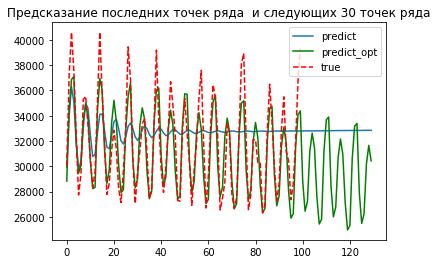

In [10]:
pred_dynamic_opt = results.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда
pred_dynamic = result_s.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда


plt.plot(pred_dynamic, label='predict' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data['PJME_MW'].values[-100:],'--r',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

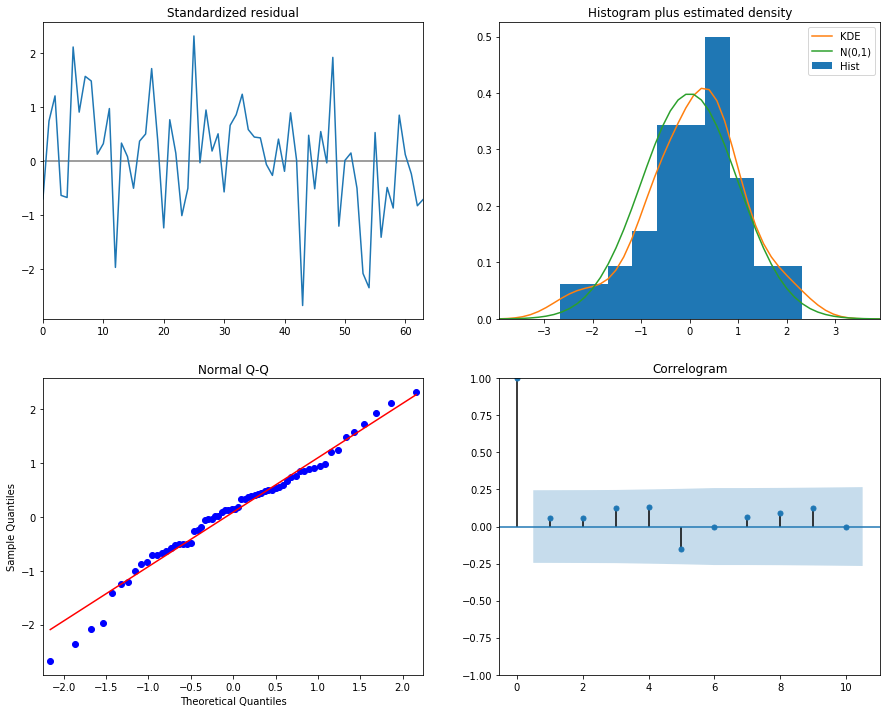

In [11]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


Оптимальная модель results показывает заметно лучший результат по сравнению с интуитивной. ЭТО УСПЕХ. Но остатки модели не совсем стационарны (хвост на Q-Q). Можно взять другие участки ряда и проверить параметры модели на них(применить кросс-проверку). Однако Коррелограма показывает. что остатки независимы, а по оценке распределения видно, что явление для остатков близко к нормальному закону.

Однако, модель в такой форме не единственная. ПОСТРОИМ МОДЕЛЬ БЕЗ СЕЗОНА.

Так можно, но модель основной части будет значительно сложней. Зададим диапазон изменения p ,q = [0,14] (период ряда 12 - сделаем запас по глубине истории и сглаживания до 14) и порядок интегрирования оставим низким

In [12]:
import itertools
# Определим p, d и q в диапазоне 0-3
p = range(0, 14)
d = range(0, 1)
q = range(0, 14)
# зададим сетку p, q и q
pdq = list(itertools.product(p, d, q))
p = range(0, 0)
d = range(0, 0)
q = range(0, 0)
seasonal_pdq =[[0,0,0,0]] # нет сезона

aics = {}

for kk in range(len(pdq)):
    for k in range(len(seasonal_pdq)):
        param = pdq[kk]
        
        print(param)
        try:
            mod_b0 = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[:-100]),
                                              order=param,seasonal_order=[0,0,0,0],trend='ct',
                                              enforce_stationarity=False,
                                              enforce_invertibility=False)

            results_0 = mod_b0.fit()
            aics[results_0.aic] = param
            print('ARIMA{}x{} - AIC:{}'.format(param, params, results_0.aic))
        except:
            continue

(0, 0, 0)
ARIMA(0, 0, 0)x(2, 1, 2, 12) - AIC:1893.6261539613054
(0, 0, 1)
ARIMA(0, 0, 1)x(2, 1, 2, 12) - AIC:1832.2941140133544
(0, 0, 2)
ARIMA(0, 0, 2)x(2, 1, 2, 12) - AIC:1790.2482610158595
(0, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 3)x(2, 1, 2, 12) - AIC:1761.627707842741
(0, 0, 4)
ARIMA(0, 0, 4)x(2, 1, 2, 12) - AIC:1739.3025455054824
(0, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 5)x(2, 1, 2, 12) - AIC:1714.8581223304548
(0, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 6)x(2, 1, 2, 12) - AIC:1702.22076186997
(0, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 7)x(2, 1, 2, 12) - AIC:1706.3292540706639
(0, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 8)x(2, 1, 2, 12) - AIC:1692.6574819036837
(0, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 9)x(2, 1, 2, 12) - AIC:1677.9411757644782
(0, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 10)x(2, 1, 2, 12) - AIC:1664.0832019529457
(0, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 11)x(2, 1, 2, 12) - AIC:1639.2266163109216
(0, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 12)x(2, 1, 2, 12) - AIC:1618.5164273637943
(0, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 13)x(2, 1, 2, 12) - AIC:1602.6405895557768
(1, 0, 0)
ARIMA(1, 0, 0)x(2, 1, 2, 12) - AIC:1868.4785914974618
(1, 0, 1)
ARIMA(1, 0, 1)x(2, 1, 2, 12) - AIC:1825.5715249466311
(1, 0, 2)
ARIMA(1, 0, 2)x(2, 1, 2, 12) - AIC:1805.5700783735829
(1, 0, 3)
ARIMA(1, 0, 3)x(2, 1, 2, 12) - AIC:1771.144904695503
(1, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 4)x(2, 1, 2, 12) - AIC:1755.0799946813813
(1, 0, 5)
ARIMA(1, 0, 5)x(2, 1, 2, 12) - AIC:1738.4295329328659
(1, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 6)x(2, 1, 2, 12) - AIC:1715.4320040978862
(1, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 7)x(2, 1, 2, 12) - AIC:1697.2549968015066
(1, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 8)x(2, 1, 2, 12) - AIC:1682.913018018031
(1, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 9)x(2, 1, 2, 12) - AIC:1669.8856843350916
(1, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 10)x(2, 1, 2, 12) - AIC:1674.706869565936
(1, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 11)x(2, 1, 2, 12) - AIC:1627.1490176728635
(1, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 12)x(2, 1, 2, 12) - AIC:1611.246180748554
(1, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 13)x(2, 1, 2, 12) - AIC:1629.8394571229903
(2, 0, 0)
ARIMA(2, 0, 0)x(2, 1, 2, 12) - AIC:1775.5118778892609
(2, 0, 1)
ARIMA(2, 0, 1)x(2, 1, 2, 12) - AIC:1789.3697228502324
(2, 0, 2)
ARIMA(2, 0, 2)x(2, 1, 2, 12) - AIC:1742.0398323224229
(2, 0, 3)
ARIMA(2, 0, 3)x(2, 1, 2, 12) - AIC:1723.798991817444
(2, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 4)x(2, 1, 2, 12) - AIC:1704.5488930431472
(2, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 5)x(2, 1, 2, 12) - AIC:1682.9221472235124
(2, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 6)x(2, 1, 2, 12) - AIC:1653.1336073894352
(2, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 7)x(2, 1, 2, 12) - AIC:1639.4028451144172
(2, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 8)x(2, 1, 2, 12) - AIC:1622.9110141163987
(2, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 9)x(2, 1, 2, 12) - AIC:1619.189417299374
(2, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 10)x(2, 1, 2, 12) - AIC:1602.7043882942373
(2, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 11)x(2, 1, 2, 12) - AIC:1593.2220661544861
(2, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 12)x(2, 1, 2, 12) - AIC:1565.0699141004498
(2, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 13)x(2, 1, 2, 12) - AIC:1555.5284308682749
(3, 0, 0)
ARIMA(3, 0, 0)x(2, 1, 2, 12) - AIC:1752.3637427926792
(3, 0, 1)
ARIMA(3, 0, 1)x(2, 1, 2, 12) - AIC:1753.6291924894003
(3, 0, 2)
ARIMA(3, 0, 2)x(2, 1, 2, 12) - AIC:1743.046307394776
(3, 0, 3)
ARIMA(3, 0, 3)x(2, 1, 2, 12) - AIC:1725.480143284153
(3, 0, 4)
ARIMA(3, 0, 4)x(2, 1, 2, 12) - AIC:1708.6426809362222
(3, 0, 5)
ARIMA(3, 0, 5)x(2, 1, 2, 12) - AIC:1685.1379574457847
(3, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 6)x(2, 1, 2, 12) - AIC:1650.9892043911607
(3, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 7)x(2, 1, 2, 12) - AIC:1630.171636503051
(3, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 8)x(2, 1, 2, 12) - AIC:1616.8956790777613
(3, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 9)x(2, 1, 2, 12) - AIC:1603.3779782017602
(3, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 10)x(2, 1, 2, 12) - AIC:1587.9480694464705
(3, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 11)x(2, 1, 2, 12) - AIC:1566.2540253640213
(3, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 12)x(2, 1, 2, 12) - AIC:1551.3108513180537
(3, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(3, 0, 13)x(2, 1, 2, 12) - AIC:1540.1383901880715
(4, 0, 0)
ARIMA(4, 0, 0)x(2, 1, 2, 12) - AIC:1731.5876056369118
(4, 0, 1)
ARIMA(4, 0, 1)x(2, 1, 2, 12) - AIC:1732.9691162172485
(4, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 2)x(2, 1, 2, 12) - AIC:1722.775603851295
(4, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 3)x(2, 1, 2, 12) - AIC:1726.285801368018
(4, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 4)x(2, 1, 2, 12) - AIC:1710.3252813232339
(4, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 5)x(2, 1, 2, 12) - AIC:1683.1368789554829
(4, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 6)x(2, 1, 2, 12) - AIC:1668.8670885679019
(4, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 7)x(2, 1, 2, 12) - AIC:1635.1750850295844
(4, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 8)x(2, 1, 2, 12) - AIC:1619.5204935194593
(4, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 9)x(2, 1, 2, 12) - AIC:1607.2060431933533
(4, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 10)x(2, 1, 2, 12) - AIC:1589.8982198046783
(4, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 11)x(2, 1, 2, 12) - AIC:1567.6568665986827
(4, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 12)x(2, 1, 2, 12) - AIC:1553.1829835730596
(4, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(4, 0, 13)x(2, 1, 2, 12) - AIC:1541.5486162876546
(5, 0, 0)
ARIMA(5, 0, 0)x(2, 1, 2, 12) - AIC:1711.814238797523
(5, 0, 1)
ARIMA(5, 0, 1)x(2, 1, 2, 12) - AIC:1713.814006850786
(5, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 2)x(2, 1, 2, 12) - AIC:1703.5819073378818
(5, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 3)x(2, 1, 2, 12) - AIC:1710.6712738217884
(5, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 4)x(2, 1, 2, 12) - AIC:1712.272629492622
(5, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 5)x(2, 1, 2, 12) - AIC:1680.2975311452842
(5, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 6)x(2, 1, 2, 12) - AIC:1665.8529749590057
(5, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 7)x(2, 1, 2, 12) - AIC:1635.0465194364829
(5, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 8)x(2, 1, 2, 12) - AIC:1625.5250407795531
(5, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 9)x(2, 1, 2, 12) - AIC:1612.9740764255696
(5, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 10)x(2, 1, 2, 12) - AIC:1596.0107766164397
(5, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 11)x(2, 1, 2, 12) - AIC:1570.0308171891352
(5, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 12)x(2, 1, 2, 12) - AIC:1558.5274103371535
(5, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(5, 0, 13)x(2, 1, 2, 12) - AIC:1540.3164846620039
(6, 0, 0)
ARIMA(6, 0, 0)x(2, 1, 2, 12) - AIC:1692.7166236820833
(6, 0, 1)
ARIMA(6, 0, 1)x(2, 1, 2, 12) - AIC:1691.9764248359481
(6, 0, 2)
ARIMA(6, 0, 2)x(2, 1, 2, 12) - AIC:1689.5508455742918
(6, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 3)x(2, 1, 2, 12) - AIC:1683.9303250137502
(6, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 4)x(2, 1, 2, 12) - AIC:1683.5571681539277
(6, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 5)x(2, 1, 2, 12) - AIC:1684.4251337451688
(6, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 6)x(2, 1, 2, 12) - AIC:1662.1946510136272
(6, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 7)x(2, 1, 2, 12) - AIC:1636.281926498078
(6, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 8)x(2, 1, 2, 12) - AIC:1625.805147574757
(6, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 9)x(2, 1, 2, 12) - AIC:1615.1571652127186
(6, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 10)x(2, 1, 2, 12) - AIC:1594.754017443519
(6, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 11)x(2, 1, 2, 12) - AIC:1574.1075899522552
(6, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 12)x(2, 1, 2, 12) - AIC:1558.8001761994337
(6, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(6, 0, 13)x(2, 1, 2, 12) - AIC:1544.3140047958302
(7, 0, 0)
ARIMA(7, 0, 0)x(2, 1, 2, 12) - AIC:1668.8756224135107
(7, 0, 1)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 1)x(2, 1, 2, 12) - AIC:1668.6249128541233
(7, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 2)x(2, 1, 2, 12) - AIC:1665.1884375936163
(7, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 3)x(2, 1, 2, 12) - AIC:1660.9472115168508
(7, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 4)x(2, 1, 2, 12) - AIC:1790.517262093382
(7, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 5)x(2, 1, 2, 12) - AIC:1683.372565414193
(7, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 6)x(2, 1, 2, 12) - AIC:1664.0709472502572
(7, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 7)x(2, 1, 2, 12) - AIC:1637.0562141676828
(7, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 8)x(2, 1, 2, 12) - AIC:1624.3600146805823
(7, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 9)x(2, 1, 2, 12) - AIC:1610.6329500073177
(7, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 10)x(2, 1, 2, 12) - AIC:1589.8510896113708
(7, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 11)x(2, 1, 2, 12) - AIC:1561.9134470889194
(7, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 12)x(2, 1, 2, 12) - AIC:1552.119060435927
(7, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(7, 0, 13)x(2, 1, 2, 12) - AIC:1544.8439901068728
(8, 0, 0)
ARIMA(8, 0, 0)x(2, 1, 2, 12) - AIC:1647.0595676870525
(8, 0, 1)
ARIMA(8, 0, 1)x(2, 1, 2, 12) - AIC:1649.0586400235427
(8, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 2)x(2, 1, 2, 12) - AIC:1651.7644041064875
(8, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 3)x(2, 1, 2, 12) - AIC:1643.8291204703337
(8, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 4)x(2, 1, 2, 12) - AIC:2247.834233985108
(8, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 5)x(2, 1, 2, 12) - AIC:1663.405083400087
(8, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 6)x(2, 1, 2, 12) - AIC:1637.9979563123525
(8, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 7)x(2, 1, 2, 12) - AIC:1634.293224708634
(8, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 8)x(2, 1, 2, 12) - AIC:1622.4232555442927
(8, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 9)x(2, 1, 2, 12) - AIC:1605.551707972902
(8, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 10)x(2, 1, 2, 12) - AIC:1584.9675741300991
(8, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 11)x(2, 1, 2, 12) - AIC:1563.6918912621918
(8, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 12)x(2, 1, 2, 12) - AIC:1553.1078204126215
(8, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(8, 0, 13)x(2, 1, 2, 12) - AIC:1537.5779100215707
(9, 0, 0)
ARIMA(9, 0, 0)x(2, 1, 2, 12) - AIC:1628.7071471766071
(9, 0, 1)
ARIMA(9, 0, 1)x(2, 1, 2, 12) - AIC:1630.5097803965116
(9, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 2)x(2, 1, 2, 12) - AIC:1625.7398800270755
(9, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 3)x(2, 1, 2, 12) - AIC:1621.6961628947086
(9, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 4)x(2, 1, 2, 12) - AIC:1678.048492422142
(9, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 5)x(2, 1, 2, 12) - AIC:1649.535224929642
(9, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 6)x(2, 1, 2, 12) - AIC:1629.0994781283264
(9, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 7)x(2, 1, 2, 12) - AIC:1620.7875792495288
(9, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 8)x(2, 1, 2, 12) - AIC:1638.71963968814
(9, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 9)x(2, 1, 2, 12) - AIC:1608.2579273981491
(9, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 10)x(2, 1, 2, 12) - AIC:1593.1119858119657
(9, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 11)x(2, 1, 2, 12) - AIC:1564.9212496885575
(9, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 12)x(2, 1, 2, 12) - AIC:1553.2223013774674
(9, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(9, 0, 13)x(2, 1, 2, 12) - AIC:1536.552128424537
(10, 0, 0)
ARIMA(10, 0, 0)x(2, 1, 2, 12) - AIC:1611.987313891561
(10, 0, 1)
ARIMA(10, 0, 1)x(2, 1, 2, 12) - AIC:1612.9404812688813
(10, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 2)x(2, 1, 2, 12) - AIC:1616.4315440437088
(10, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 3)x(2, 1, 2, 12) - AIC:1605.631976875647
(10, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 4)x(2, 1, 2, 12) - AIC:1616.0659956632628
(10, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 5)x(2, 1, 2, 12) - AIC:1626.3792747848977
(10, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 6)x(2, 1, 2, 12) - AIC:1619.202138972202
(10, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 7)x(2, 1, 2, 12) - AIC:1606.5560310677254
(10, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 8)x(2, 1, 2, 12) - AIC:1616.77333289963
(10, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 9)x(2, 1, 2, 12) - AIC:1618.6294031833113
(10, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 10)x(2, 1, 2, 12) - AIC:1606.8388343278868
(10, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 11)x(2, 1, 2, 12) - AIC:1579.5998892706102
(10, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 12)x(2, 1, 2, 12) - AIC:1553.6572326631722
(10, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(10, 0, 13)x(2, 1, 2, 12) - AIC:1538.1663335260207
(11, 0, 0)
ARIMA(11, 0, 0)x(2, 1, 2, 12) - AIC:1580.891650122327
(11, 0, 1)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 1)x(2, 1, 2, 12) - AIC:1581.6641098555697
(11, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 2)x(2, 1, 2, 12) - AIC:1582.5900143993606
(11, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 3)x(2, 1, 2, 12) - AIC:1582.5813505352098
(11, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 4)x(2, 1, 2, 12) - AIC:1599.7810487180072
(11, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 5)x(2, 1, 2, 12) - AIC:1591.4124471302732
(11, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 6)x(2, 1, 2, 12) - AIC:1628.466124532795
(11, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 7)x(2, 1, 2, 12) - AIC:1584.4504155746588
(11, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 8)x(2, 1, 2, 12) - AIC:1589.9105335303645
(11, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 9)x(2, 1, 2, 12) - AIC:1591.3624589192402
(11, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 10)x(2, 1, 2, 12) - AIC:1596.0935561020644
(11, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 11)x(2, 1, 2, 12) - AIC:1573.288190514429
(11, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 12)x(2, 1, 2, 12) - AIC:1577.4010534190315
(11, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(11, 0, 13)x(2, 1, 2, 12) - AIC:1536.218014119624
(12, 0, 0)
ARIMA(12, 0, 0)x(2, 1, 2, 12) - AIC:1560.517558469981
(12, 0, 1)
ARIMA(12, 0, 1)x(2, 1, 2, 12) - AIC:1562.4816555921518
(12, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 2)x(2, 1, 2, 12) - AIC:1564.8284687070427
(12, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 3)x(2, 1, 2, 12) - AIC:1564.4006666056907
(12, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 4)x(2, 1, 2, 12) - AIC:1564.6527321997264
(12, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 5)x(2, 1, 2, 12) - AIC:1566.4962759818804
(12, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 6)x(2, 1, 2, 12) - AIC:1742.624885789276
(12, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 7)x(2, 1, 2, 12) - AIC:1588.7896639353553
(12, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 8)x(2, 1, 2, 12) - AIC:1564.5745969610093
(12, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 9)x(2, 1, 2, 12) - AIC:1563.6399467546548
(12, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 10)x(2, 1, 2, 12) - AIC:1576.1259834121925
(12, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 11)x(2, 1, 2, 12) - AIC:1567.3790418838444
(12, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 12)x(2, 1, 2, 12) - AIC:1584.4105317340275
(12, 0, 13)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(12, 0, 13)x(2, 1, 2, 12) - AIC:1548.3637969144522
(13, 0, 0)
ARIMA(13, 0, 0)x(2, 1, 2, 12) - AIC:1543.6259468435649
(13, 0, 1)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 1)x(2, 1, 2, 12) - AIC:1545.228733483733
(13, 0, 2)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 2)x(2, 1, 2, 12) - AIC:1546.9497574594864
(13, 0, 3)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 3)x(2, 1, 2, 12) - AIC:1548.2939669548125
(13, 0, 4)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 4)x(2, 1, 2, 12) - AIC:1544.333047649073
(13, 0, 5)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 5)x(2, 1, 2, 12) - AIC:1543.9619130841995
(13, 0, 6)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 6)x(2, 1, 2, 12) - AIC:1682.3915651439913
(13, 0, 7)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 7)x(2, 1, 2, 12) - AIC:1556.0889150742237
(13, 0, 8)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 8)x(2, 1, 2, 12) - AIC:1552.5463923250647
(13, 0, 9)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 9)x(2, 1, 2, 12) - AIC:1550.2803305529594
(13, 0, 10)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 10)x(2, 1, 2, 12) - AIC:1557.5838378638587
(13, 0, 11)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 11)x(2, 1, 2, 12) - AIC:1548.981057820728
(13, 0, 12)


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(13, 0, 12)x(2, 1, 2, 12) - AIC:1566.3827965465048
(13, 0, 13)
ARIMA(13, 0, 13)x(2, 1, 2, 12) - AIC:1544.531853664372


C:\Anaconda\lib\site-packages\statsmodels\base\model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Посмотрим на качество моделей

In [13]:
aics


{1893.6261539613054: (0, 0, 0),
 1832.2941140133544: (0, 0, 1),
 1790.2482610158595: (0, 0, 2),
 1761.627707842741: (0, 0, 3),
 1739.3025455054824: (0, 0, 4),
 1714.8581223304548: (0, 0, 5),
 1702.22076186997: (0, 0, 6),
 1706.3292540706639: (0, 0, 7),
 1692.6574819036837: (0, 0, 8),
 1677.9411757644782: (0, 0, 9),
 1664.0832019529457: (0, 0, 10),
 1639.2266163109216: (0, 0, 11),
 1618.5164273637943: (0, 0, 12),
 1602.6405895557768: (0, 0, 13),
 1868.4785914974618: (1, 0, 0),
 1825.5715249466311: (1, 0, 1),
 1805.5700783735829: (1, 0, 2),
 1771.144904695503: (1, 0, 3),
 1755.0799946813813: (1, 0, 4),
 1738.4295329328659: (1, 0, 5),
 1715.4320040978862: (1, 0, 6),
 1697.2549968015066: (1, 0, 7),
 1682.913018018031: (1, 0, 8),
 1669.8856843350916: (1, 0, 9),
 1674.706869565936: (1, 0, 10),
 1627.1490176728635: (1, 0, 11),
 1611.246180748554: (1, 0, 12),
 1629.8394571229903: (1, 0, 13),
 1775.5118778892609: (2, 0, 0),
 1789.3697228502324: (2, 0, 1),
 1742.0398323224229: (2, 0, 2),
 1723.7

Выбираем модель (12,0,0) - самая простая из хороших (около 1500 по AIC) - вот опять сезонность с лагом 12.

In [14]:
result_2 = sm.tsa.statespace.SARIMAX((data['PJME_MW'].values[-500:-100]),
                                          order=[12,0, 0],seasonal_order=[0,0,0,0],trend='ct',
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
result_s_0 = result_2.fit()    

Нарисуем : модель похожа на модель с сезонностью (несколько хуже, т.к. она проще ). Цикли проявлены, для предсказания имеем неплохой результат, но остатки этой модели не идеальны (хвосты на Q-Q).

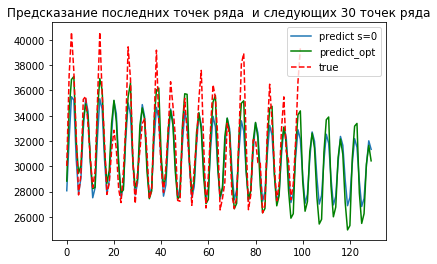

In [15]:
pred_dynamic_opt = results.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда
pred_dynamic_s0 = result_s_0.forecast(len(data['PJME_MW'].values[:-100])+30)    #делаем предсказание на 10 точки от текущего конца ряда


plt.plot(pred_dynamic_s0, label='predict s=0' )
plt.plot(pred_dynamic_opt,'g', label='predict_opt' )
#Отобразим истинный значения 
plt.plot(data['PJME_MW'].values[-100:],'--r',label='true')
plt.title('Предсказание последних точек ряда  и следующих 30 точек ряда')
plt.legend()

plt.show()

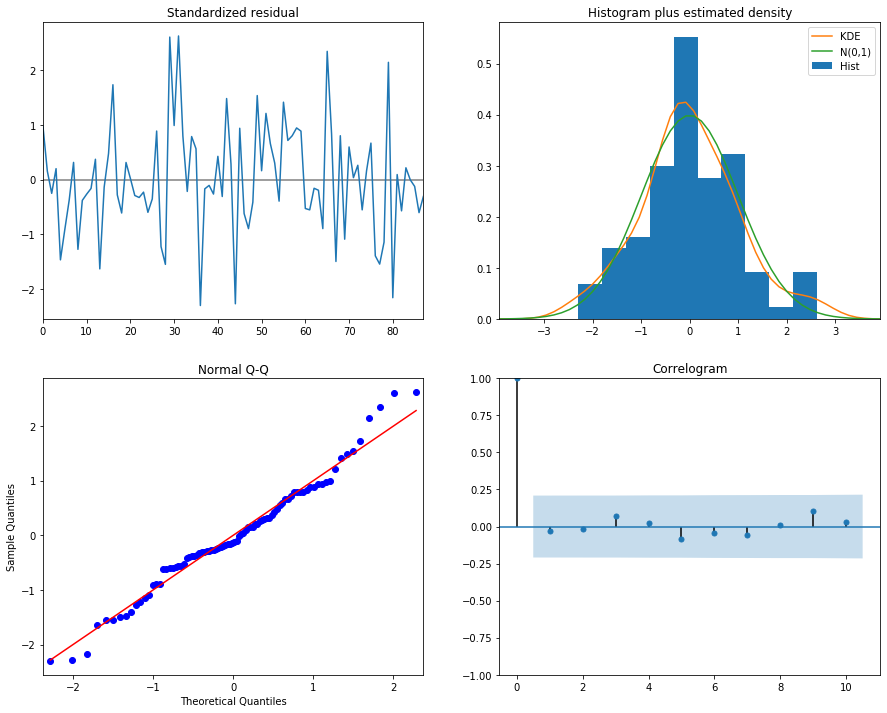

In [16]:
result_s_0.plot_diagnostics(figsize=(15, 12))
plt.show()


Единственной моедли нет. Есть несколько близких хороших моделей.!!